In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input, Flatten, concatenate
from keras import Model
import pandas as pd
import matplotlib.pyplot as plt

### Create layer architecture as specified in diagram

#### 8 Inputs:
- From Visible Image
    - Laplacian Variance (Scalar)
    - DCT Power Spectrum in the x-axis (1D Array)
    - DCT Power Spectrum in the y-axis (1D Array)
- From Infrared Image
    - Laplacian Variance (Scalar)
    - DCT Power Spectrum in the x-axis (1D Array)
    - DCT Power Spectrum in the y-axis (1D Array)
- From Lidar Point Cloud
    - Pings vs. Depth Distribution (1D Array)
    - Depth Map (2D Matrix)

Abbreivations:
- Laplacian Variance --> lapVar
- DCT Power Spectrums --> dctPowerX, dctPowerY
- Lidar Pings vs. Depth Distribution --> pingDist
- Depth Map --> depthMap

### Parameters

In [2]:
dctPowerX_length = int(512/2)+1
dctPowerY_length = int(640/2)+1
pingDist_length = 100
depthMap_length = 25*20

### Visible Inputs

In [3]:
visible_lapVar = Input(shape=(1,),  # Scalar
                       name="Visible_Laplacian_Variance",
                       dtype="float32")

visible_dctPowerX = Input(shape=(dctPowerX_length-2,), # 1D array
                          name="Visible_Power_Spectrum_X",
                          dtype="float32")

visible_dctPowerY = Input(shape=(dctPowerY_length,), # 1D array
                          name="Visible_Power_Spectrum_Y",
                          dtype="float32")

# Combine all 3 inputs into 1 layer
visibleCombined = concatenate([visible_lapVar,
                               visible_dctPowerX,
                               visible_dctPowerY],
                               name="Combined_Visible")

### Infrared Inputs

In [4]:
infrared_lapVar = Input(shape=(1,),  # Scalar
                       name="Infrared_Laplacian_Variance",
                       dtype="float32")

infrared_dctPowerX = Input(shape=(dctPowerX_length,), # 1D array
                          name="Infrared_Power_Spectrum_X",
                          dtype="float32")

infrared_dctPowerY = Input(shape=(dctPowerY_length,), # 1D array
                          name="Infrared_Power_Spectrum_Y",
                          dtype="float32")

# Combine all 3 inputs into 1 layer
infraredCombined = concatenate([infrared_lapVar,
                               infrared_dctPowerX,
                               infrared_dctPowerY],
                               name="Combined_Infrared")

### Lidar Inputs

In [5]:
lidar_pingDist= Input(shape=(pingDist_length,),  # 1D array
                      name="Lidar_Ping_Distribution",
                      dtype="float32")

lidar_depthMap = Input(shape=depthMap_length, # 2D array flattened into 1D
                       name="Lidar_Depth_Map",
                       dtype="float32")

# Flatten depth map into 1D
# lidar_depthMapFlat = Flatten()(lidar_depthMap)

# Combine all 2 inputs into 1 layer
lidarCombined = concatenate([lidar_pingDist,
                             lidar_depthMap],
                             name="Combined_Lidar")

### "Intermediary" dense layers for each instrument

Prior to combining the data from all three cameras (visible, infrared, and
Lidar), there will be a three dense layers that train on each camera
individually. We hope this will better summarize the three data streams prior
to combining all of them together.

In [6]:
neuronsPerLayer = 32  # Hm...

visibleDense = Dense(units=neuronsPerLayer,
                     activation="sigmoid",
                     name="Visible_Dense_Layer")(visibleCombined)

infraredDense = Dense(units=neuronsPerLayer,
                      activation="sigmoid",
                      name="Infrared_Dense_Layer")(infraredCombined)

lidarDense = Dense(units=neuronsPerLayer,
                      activation="sigmoid",
                      name="Lidar_Dense_Layer")(lidarCombined)

allImageryCombined = concatenate([visibleDense,
                                  infraredDense,
                                  lidarDense],
                                  name="Combined_Neurons")

### More Dense Layers

Now that we have the imagery inputs in three separate dense layers, we can now feed these layers into more dense layers that integrate the data held by all instruments.

How many layers are optimal for neural network training? There is no good, analytical way to determine this, but we will choose use 3 for our model. The number of neurons will decrease for the layers closer to the output, as the weights in the third layer should have more refinement and than the first layer.

We will use the relu (rectified linear unit) activiation function, as this is the most basic activiation function and does not suffer from the vanishing gradient problem (cite this too).

Future work could run a parameter study with the number of layers, the number of neurons within each layer, and the activiation function to determine the optimum configuration.

https://www.v7labs.com/blog/neural-networks-activation-functions#h5


In [7]:
neuronsInLayers = [64, 32, 16]  # This are arbitrarily-picked values

firstDense = Dense(units=neuronsInLayers[0],
                   activation="sigmoid",
                   name="First_Dense_Layer")(allImageryCombined)

secondDense = Dense(units=neuronsInLayers[1],
                   activation="sigmoid",
                   name="Second_Dense_Layer")(firstDense)

thirdDense = Dense(units=neuronsInLayers[2],
                   activation="sigmoid",
                   name="Third_Dense_Layer")(secondDense)

### Output Layer

Our neural network will have two outputs (neurons): the ML-derived estimate for meteorological optical range (MOR) and liquid water content (LWC) of the environment that was captured with the visible, infrared, and lidar cameras.

We will use the Relu activation function again (instead of the linear activation function), as both MOR and LWC cannot be negative. In other words, an estimate of 0 (lower bound of Relu) is better than any negative estimate (lower bound of linear).

https://towardsdatascience.com/deep-learning-which-loss-and-activation-functions-should-i-use-ac02f1c56aa8

In [8]:
estimates = Dense(2,
                  activation="relu",
                  name="MOR_and_LWC_estimates")(thirdDense)

### Putting everything together...

In [9]:
neuralNetwork = Model(
                      inputs=[visible_lapVar,
                              visible_dctPowerX,
                              visible_dctPowerY,
                              infrared_lapVar,
                              infrared_dctPowerX,
                              infrared_dctPowerY,
                              lidar_pingDist,
                              lidar_depthMap],
                      outputs=estimates
)

### Visualize Path of Data Through Neural Network

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Visible_Laplacian_Variance (In  [(None, 1)]         0           []                               
 putLayer)                                                                                        
                                                                                                  
 Visible_Power_Spectrum_X (Inpu  [(None, 255)]       0           []                               
 tLayer)                                                                                          
                                                                                                  
 Visible_Power_Spectrum_Y (Inpu  [(None, 321)]       0           []                               
 tLayer)                                                                                      

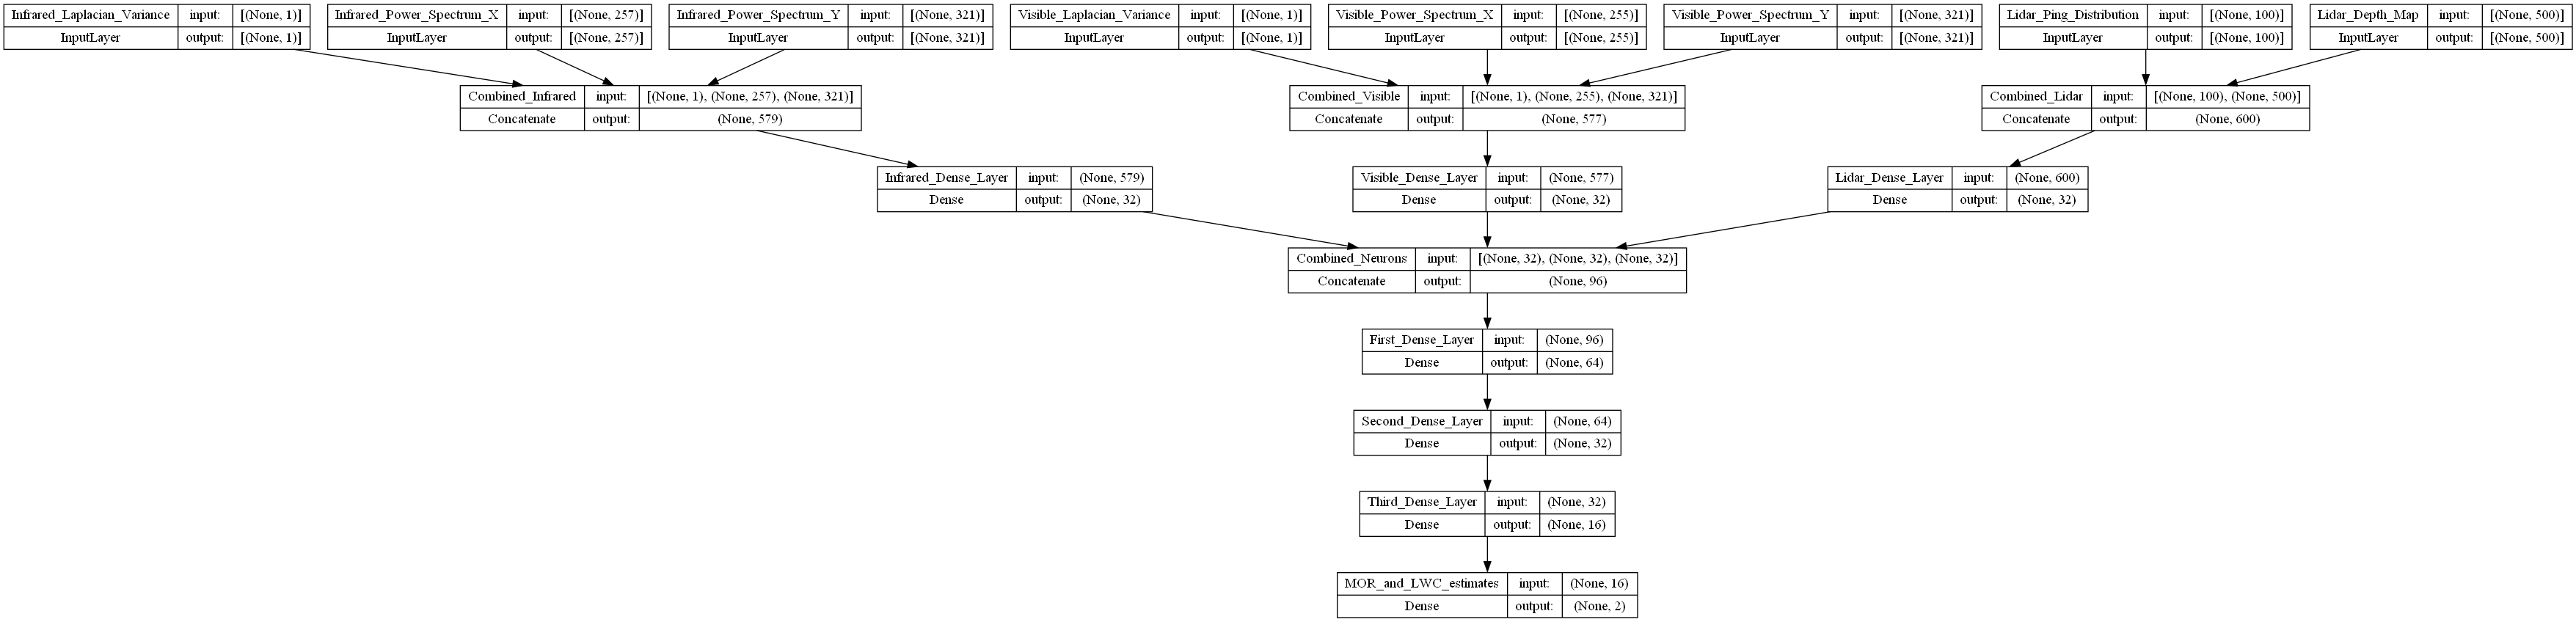

In [10]:
neuralNetwork.summary()
keras.utils.plot_model(neuralNetwork, show_shapes=True)

### Compile the Neural Network

Add the loss function and optimizer.

In [11]:
neuralNetwork.compile(loss="mean_squared_error",
                      optimizer="adam",
                      metrics=['mean_squared_error'])

### Load in the data

In [12]:
# Dummy input data
'''
numCorrelatedImages = 500

fakeLidarDepthMap = np.random.rand(numCorrelatedImages, depthMap_dimensions[0], depthMap_dimensions[1])
fakeLidarPingDist = np.random.rand(numCorrelatedImages, pingDist_length)

fakeVisibleLapVar = np.random.rand(numCorrelatedImages)
fakeVisibleDCT_X = np.random.rand(numCorrelatedImages, dctPowerX_length)
fakeVisibleDCT_Y = np.random.rand(numCorrelatedImages, dctPowerY_length)

fakeInfraredLapVar = np.random.rand(numCorrelatedImages)
fakeInfraredDCT_X = np.random.rand(numCorrelatedImages, dctPowerX_length)
fakeInfraredDCT_Y = np.random.rand(numCorrelatedImages, dctPowerY_length)

inputs = {"Lidar_Depth_Map": fakeLidarDepthMap,
          "Lidar_Ping_Distribution": fakeLidarPingDist,
          "Visible_Laplacian_Variance": fakeVisibleLapVar,
          "Visible_Power_Spectrum_X": fakeVisibleDCT_X,
          "Visible_Power_Spectrum_Y": fakeVisibleDCT_Y,
          "Infrared_Laplacian_Variance": fakeInfraredLapVar,
          "Infrared_Power_Spectrum_X": fakeInfraredDCT_X,
          "Infrared_Power_Spectrum_Y": fakeInfraredDCT_Y,}

outputs = {"MOR_and_LWC_estimates": np.random.rand(numCorrelatedImages, 2)}
'''

# Load in actual data
from NN_Functions import getFog16Data

# Get fog16 data
(train_set, test_set, MOR_normInfo, LWC_normInfo, input_normInfo) = getFog16Data()

Train the Neural Network!

In [13]:
history = neuralNetwork.fit(train_set['inputs'], train_set['outputs'],
                            epochs=30,
                            batch_size=256,  # Number of images to process per weight-update, typically a power of 2
                            initial_epoch=0
)

Epoch 1/30
11/11 [==============================] - 1s 6ms/step - loss: 0.1199 - mean_squared_error: 0.1199
Epoch 2/30
11/11 [==============================] - 0s 5ms/step - loss: 0.1094 - mean_squared_error: 0.1094
Epoch 3/30
11/11 [==============================] - 0s 5ms/step - loss: 0.1033 - mean_squared_error: 0.1033
Epoch 4/30
11/11 [==============================] - 0s 5ms/step - loss: 0.0977 - mean_squared_error: 0.0977
Epoch 5/30
11/11 [==============================] - 0s 5ms/step - loss: 0.0857 - mean_squared_error: 0.0857
Epoch 6/30
11/11 [==============================] - 0s 5ms/step - loss: 0.0653 - mean_squared_error: 0.0653
Epoch 7/30
11/11 [==============================] - 0s 5ms/step - loss: 0.0391 - mean_squared_error: 0.0391
Epoch 8/30
11/11 [==============================] - 0s 5ms/step - loss: 0.0170 - mean_squared_error: 0.0170
Epoch 9/30
11/11 [==============================] - 0s 5ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 10/30
11/11 [=========

Get ML-derived values of MOR and LWC for both the training and test dataset

In [14]:
# Fit test data
testAnswers = neuralNetwork.predict(test_set["inputs"])
MOR_actual = testAnswers[:, 0] * MOR_normInfo["scale"] + MOR_normInfo["offset"]
LWC_actual = testAnswers[:, 1] * LWC_normInfo["scale"] + LWC_normInfo["offset"]

# testAnswers = np.array#

testAnswers = np.vstack((MOR_actual, LWC_actual)).T

19/19 [==============================] - 0s 3ms/step


Plot ground truth MOR and LWC values against ML-derived ones

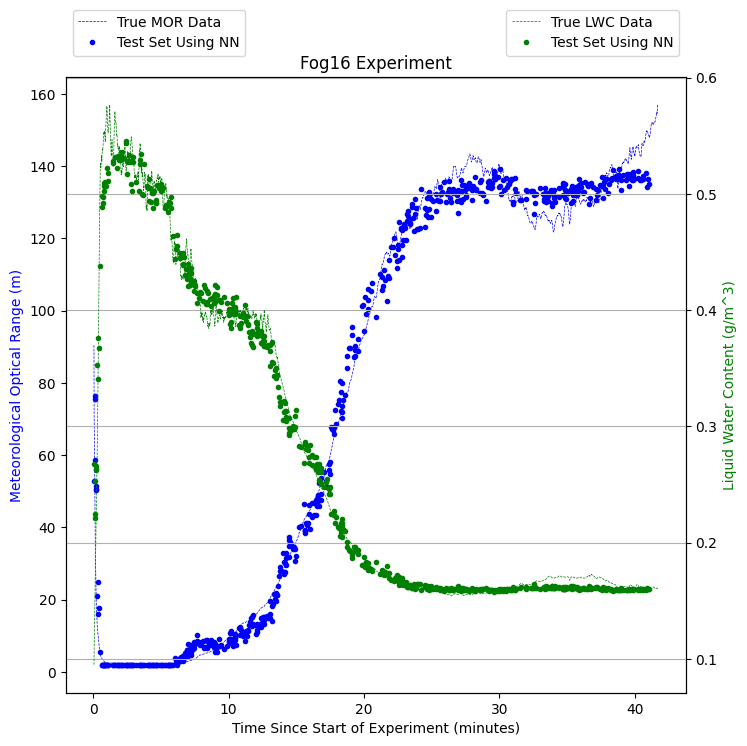

In [15]:
# Plot "real" fog16 data
boxFolder = "c:\\Users\\andy1\\Box\\"
csvsPath = boxFolder + "Glenn I Data\Csvs for Neural Network\\"
df = pd.read_csv(csvsPath + "fog16_data_withLapVars.csv")

fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()

# Plot initialization
plt.grid(True, which="both")
ax1.set_xlabel("Time Since Start of Experiment (minutes)")
ax1.set_title("Fog16 Experiment")

ax1.set_ylabel("Meteorological Optical Range (m)", color=[0, 0, 1])
ax2.set_ylabel("Liquid Water Content (g/m^3)", color=[0,0.5,0])

# Plot ground truth
ax1.plot(df["timeSinceStart"]/60, df["MOR532_m_filt"], "b--", linewidth=0.5)
ax2.plot(df["timeSinceStart"]/60, df["LWC_gm3_filt"], "g--", linewidth=0.5)

# Plot training data after training
#ax1.plot(df.loc[train_set['indexes'], "timeSinceStart"]/60, trainAnswers[:, 0], "b.")
#ax2.plot(df.loc[train_set['indexes'], "timeSinceStart"]/60, trainAnswers[:, 1], "g.")

# Plot test data
ax1.plot(df.loc[test_set['indexes'], "timeSinceStart"]/60, testAnswers[:, 0], "b.")
ax2.plot(df.loc[test_set['indexes'], "timeSinceStart"]/60, testAnswers[:, 1], "g.")

ax1.legend(["True MOR Data", "Test Set Using NN"], bbox_to_anchor=(0, 1.12), loc='upper left')
ax2.legend(["True LWC Data", "Test Set Using NN"], bbox_to_anchor=(1, 1.12), loc='upper right')

Plot loss as a function of epoch number

Text(0.5, 1.0, 'Training on 80% of fog16')

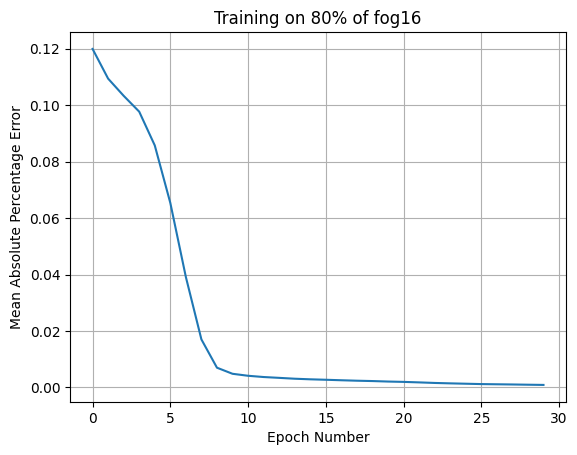

In [16]:
plt.grid(True)
plt.plot(history.history['loss'])
plt.xlabel("Epoch Number")
plt.ylabel("Mean Absolute Percentage Error")
plt.title("Training on 80% of fog16")

Save neural network with all of its now-trained weights/values

In [21]:
# Save the model
# neuralNetwork.save("4-12 Neural Network Post-Training")

# To get it back into Python
# neuralNetwork = keras.models.load_model("3-24 Neural Network Post-Training")

INFO:tensorflow:Assets written to: 4-12 Neural Network Post-Training\assets


INFO:tensorflow:Assets written to: 4-12 Neural Network Post-Training\assets


## Overfitting Analysis

The baseline07 and baseline08 tests have the same distance to the USAF-1951
target as the fog16 test. Consequently, the neural network trained on fog16
should be valid for these two baseline tests.

As the baseline tests captured data with no fog data, the MOR and LWC values
from the NN should be roughly constant. A non-constant MOR or LWC value would
suggest that the NN overfitted on the fog16 data.

Note: Why not compare the NN-derived values of MOR and LWC for these two baseline
tests with the ground truth? Unfortunately, this is not possible, as the
transmissometer and Malvern were not collecting data during the baseline tests.
Consequently, there is no "ground truth" MOR/LWC data for baseline07 and baseline08.

In [18]:
# Load in actual data
from NN_Functions import getBaselineData

# Get data for both baseline07 and baseline08
baseline07_data = getBaselineData("baseline07", input_normInfo)
baseline08_data = getBaselineData("baseline08", input_normInfo)

# Get NN-derived values for both tests
baseline07_outputs = neuralNetwork.predict(baseline07_data["inputs"])
MOR_07 = baseline07_outputs[:, 0] * MOR_normInfo["scale"] + MOR_normInfo["offset"]
LWC_07 = baseline07_outputs[:, 1] * LWC_normInfo["scale"] + LWC_normInfo["offset"]
baseline07_outputs = np.vstack((MOR_07, LWC_07)).T

baseline08_outputs = neuralNetwork.predict(baseline08_data["inputs"])
MOR_08 = baseline08_outputs[:, 0] * MOR_normInfo["scale"] + MOR_normInfo["offset"]
LWC_08 = baseline08_outputs[:, 1] * LWC_normInfo["scale"] + LWC_normInfo["offset"]
baseline08_outputs = np.vstack((MOR_08, LWC_08)).T

4/4 [==============================] - 0s 3ms/step


Plot NN-derived MOR and LWC values for baseline07

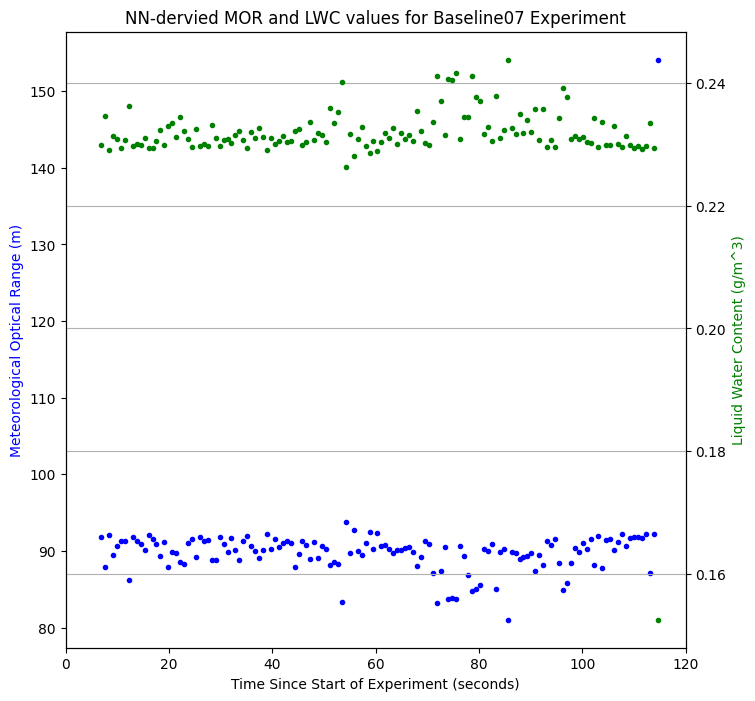

In [19]:
boxFolder = "c:\\Users\\andy1\\Box\\"
csvsPath = boxFolder + "Glenn I Data\Csvs for Neural Network\\"

df = pd.read_csv(csvsPath + "baseline07_data_withLapVars.csv")

fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()

# Plot initialization
plt.grid(True, which="both")
ax1.set_xlabel("Time Since Start of Experiment (seconds)")
ax1.set_title("NN-dervied MOR and LWC values for Baseline07 Experiment")
plt.xlim([0, 120])

ax1.set_ylabel("Meteorological Optical Range (m)", color=[0, 0, 1])
ax2.set_ylabel("Liquid Water Content (g/m^3)", color=[0,0.5,0])

# Plot values
ax1.plot(df["timeSinceStart"], baseline07_outputs[:, 0], "b.")
ax2.plot(df["timeSinceStart"], baseline07_outputs[:, 1], "g.")

Plot NN-derived MOR and LWC values for baseline08

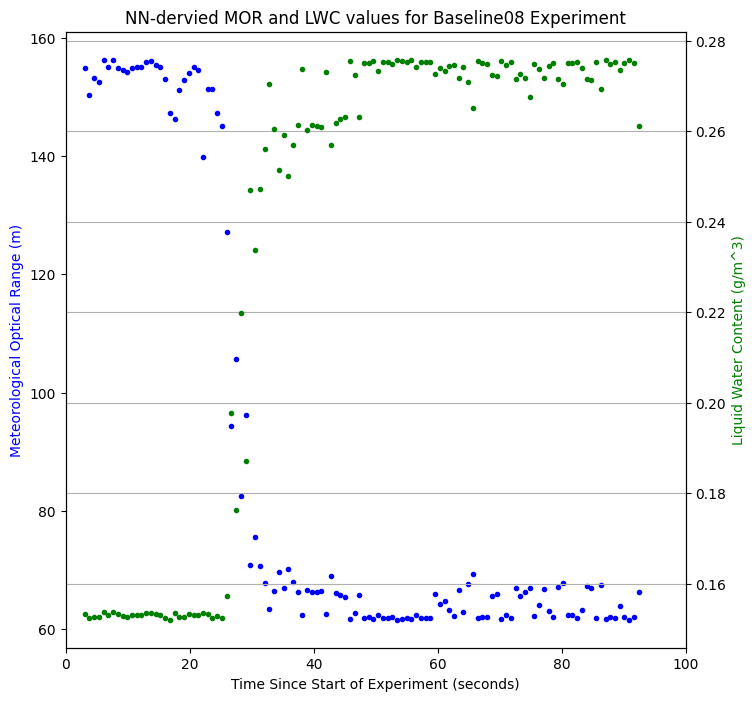

In [20]:
boxFolder = "c:\\Users\\andy1\\Box\\"
csvsPath = boxFolder + "Glenn I Data\Csvs for Neural Network\\"

df = pd.read_csv(csvsPath + "baseline08_data_withLapVars.csv")

fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()

# Plot initialization
plt.grid(True, which="both")
ax1.set_xlabel("Time Since Start of Experiment (seconds)")
ax1.set_title("NN-dervied MOR and LWC values for Baseline08 Experiment")
plt.xlim([0, 100])

ax1.set_ylabel("Meteorological Optical Range (m)", color=[0, 0, 1])
ax2.set_ylabel("Liquid Water Content (g/m^3)", color=[0,0.5,0])

# Plot values
ax1.plot(df["timeSinceStart"], baseline08_outputs[:, 0], "b.")
ax2.plot(df["timeSinceStart"], baseline08_outputs[:, 1], "g.")